# Lab 2: Data exploration

In HW1, we did some basic data exploration and visualization. In this lab, we will continue digging through the 311 datasets for more data wrangling and exploration practice. Specifically, we'll focus on geographical visualizations.

To start we'll need to install the following python libraries:
- geopandas
- folium

Install them with pip/conda:

<code>pip install geopandas
pip install folium
</code>

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

As you've probably noticed while doing your homework, different neighborhoods/zipcodes have different distributions of 311 requests. We will attempt to visualize these differences.

Before we start, we'll need an the boundaries of the Chicago zipcodes, which we can get from: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw

First let's load our datasets and the zipcode geojson.

In [3]:
# Load as many rows as you want
size = 20000
# Change these filepaths
rod_df = pd.read_csv('data/311_rodent.csv', nrows=size)
vac_df = pd.read_csv('data/311_vacant.csv', nrows=size)
geo_df = gpd.read_file('data/chicago_boundaries_zip.geojson')

In [4]:
# Some preprocessing
vac_df.drop(columns=['IS THE BUILDING DANGEROUS OR HAZARDOUS?'], inplace=True)
vac_df.dropna(inplace=True)
rod_df.dropna(inplace=True)
vac_df['zip'] = vac_df['ZIP CODE'].astype(int)
rod_df['zip'] = rod_df['ZIP Code'].astype(int)
geo_df['zip'] = geo_df['zip'].astype(int)

## Choropleth Maps with geopandas
geopandas.read_file takes in a geojson file and creates a GeoDataFrame. You can read more about it from the [geopandas api](http://geopandas.org/data_structures.html). The GeoDataFrame can then be plotted right off the bat:

In [5]:
geo_df.head()

,objectid,shape_len,zip,shape_area,geometry
0,33,42720.0444058,60647,106052287.488,(POLYGON ((-87.67762151065281 41.9177578010629...
1,34,48103.7827213,60639,127476050.762,(POLYGON ((-87.72683253163021 41.9226462671259...
2,35,27288.6096123,60707,45069038.4783,(POLYGON ((-87.78500237831095 41.9091478547167...
3,36,42527.9896789,60622,70853834.3797,(POLYGON ((-87.6670686895295 41.88885188496992...
4,37,47970.1401531,60651,99039621.2518,(POLYGON ((-87.70655631674127 41.8955534069940...


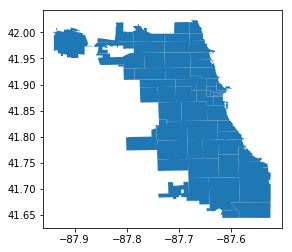

In [6]:
geo_df.plot()

This is not too interesting so let's try to make the plot tell us something about each of the zipcodes. We can do this by setting the column parameter which will then shade the zipcode block according to that column. You can supply a [matplotlib colormap](https://matplotlib.org/examples/color/colormaps_reference.html) string for the cmap parameter for different types of color gradients.

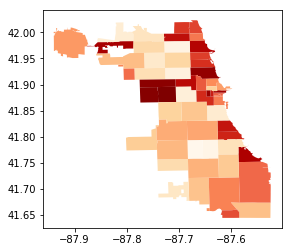

In [7]:
geo_df.plot(column='shape_area', cmap='OrRd')

Now, let's augment this geoDataFrame with a new column for the number of 311 requests of rodent complaints to see something a bit more interesting. To do this we'll create a dataframe for the number of 311 requests that each zipcode received in aggregate, and merge this to geo_df

In [8]:
rod_df.columns

Index(['Creation Date', 'Status', 'Completion Date', 'Service Request Number',
       'Type of Service Request', 'Number of Premises Baited',
       'Number of Premises with Garbage', 'Number of Premises with Rats',
       'Current Activity', 'Most Recent Action', 'Street Address', 'ZIP Code',
       'X Coordinate', 'Y Coordinate', 'Ward', 'Police District',
       'Community Area', 'Latitude', 'Longitude', 'Location', 'zip'],
      dtype='object')

In [9]:
# Get the counts
rod_zip_counts = rod_df.groupby('zip').count()
vac_zip_counts = vac_df.groupby('zip').count()
# Make a smaller dataframe with two columns: "zip" and "count"
r_zipcounts = pd.DataFrame({'zip': rod_zip_counts.index, 'count': rod_zip_counts['Status']})
v_zipcounts = pd.DataFrame({'zip': vac_zip_counts.index, 'count': vac_zip_counts['Ward']})
print(r_zipcounts.head())
print(v_zipcounts.head())

       count    zip
zip                
60601      8  60601
60602      4  60602
60603      6  60603
60604      5  60604
60605     31  60605
       count    zip
zip                
60601      1  60601
60605      8  60605
60607      8  60607
60608     82  60608
60609    370  60609


In [10]:
# Join them onto geo_df
rjoined = geo_df.join(r_zipcounts, on='zip', how='left', lsuffix='l', rsuffix='r')
vjoined = geo_df.join(v_zipcounts, on='zip', how='left', lsuffix='l', rsuffix='r')
# There is probably a cleaner way to do this, but I'll let you figure that out.

In [11]:
rjoined[:10]

,objectid,shape_len,zipl,shape_area,geometry,count,zipr
0,33,42720.0444058,60647,106052287.488,(POLYGON ((-87.67762151065281 41.9177578010629...,1197,60647
1,34,48103.7827213,60639,127476050.762,(POLYGON ((-87.72683253163021 41.9226462671259...,533,60639
2,35,27288.6096123,60707,45069038.4783,(POLYGON ((-87.78500237831095 41.9091478547167...,168,60707
3,36,42527.9896789,60622,70853834.3797,(POLYGON ((-87.6670686895295 41.88885188496992...,530,60622
4,37,47970.1401531,60651,99039621.2518,(POLYGON ((-87.70655631674127 41.8955534069940...,611,60651
5,38,34689.3506306,60611,23506055.7304,(POLYGON ((-87.61401200402452 41.8935399774544...,35,60611
6,39,67710.6467392,60638,166166339.096,(POLYGON ((-87.74346534021549 41.8187595760259...,185,60638
7,40,48187.9498796,60652,128309832.185,(POLYGON ((-87.68304800178444 41.7574074219291...,328,60652
8,1,33983.9133065,60626,49170578.9623,(POLYGON ((-87.66420656495005 42.0212628985839...,164,60626
9,2,32075.5994211,60645,62181473.5197,(POLYGON ((-87.68838321208516 42.0195191131405...,275,60645


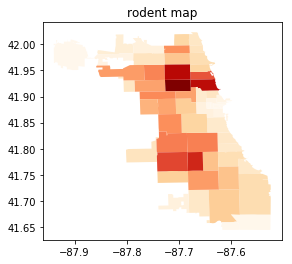

In [12]:
# Plot the map color coded by number of rodent 311 requests
rjoined.plot(column='count', cmap='OrRd')
plt.title('rodent map')
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


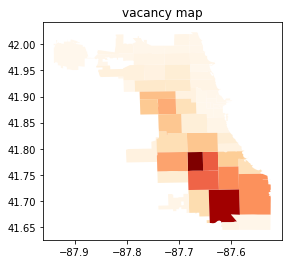

In [13]:
# Plot the map color coded by number of vacancy calls
vjoined.plot(column='count', cmap='OrRd')
plt.title('vacancy map')
plt.show()

## Heatmaps with folium

While these visualizations are useful in summarizing where we might expect more rodent/vacancy/etc requests to come from, they're a bit coarse because zipcode blocks can be pretty big. To get a finer grained view of where these requests happen, we'll learn how to plot a heatmap of these 311 requests using folium.

Recall that our 311 data contains the latitude and longitude of these values.

In [14]:
rod_xy = rod_df[['Latitude', 'Longitude']]
vac_xy = vac_df[['LATITUDE', 'LONGITUDE']]

In [15]:
import folium
from folium.plugins import HeatMap

In [16]:
print(rod_xy.mean())
print(vac_xy.mean())

Latitude     41.873109
Longitude   -87.690398
dtype: float64
LATITUDE     41.793119
LONGITUDE   -87.664039
dtype: float64


In [17]:
hmap = folium.Map(location=[41.87, -87.69], zoom_start=10)
hm_rod = [[row['Latitude'], row['Longitude']] for index, row in rod_xy.iterrows()]
HeatMap(hm_rod, radius=13, blur=20).add_to(hmap)
hmap

In [18]:
vac_xy.columns

Index(['LATITUDE', 'LONGITUDE'], dtype='object')

You should see something like:
![Vacancy heatmap](imgs/rod.png)

In [19]:
hmap = folium.Map(location=[41.87, -87.69], zoom_start=10)
#hm_rod = HeatMap(zip(vac_xy['LATITUDE'].values, vac_xy['LONGITUDE'].values), radius=14, blur=20)
#hmap.add_child(hm_rod)

hm_rod = [[row['LATITUDE'], row['LONGITUDE']] for index, row in vac_xy.iterrows()]
HeatMap(hm_rod, radius=13, blur=20).add_to(hmap)
hmap

![Vacancy heatmap](imgs/vac.png)

Play around with the zoom_start, radius and blur parameters to get a better sense of how they affect the resulting visualizations.

# Exercises:
Now that we've seen how to create some simple geographical visualizations you should aggregate the 311 requests by zipcode and visualize request frequency, average request completion time by location, and any other things you find interesting. Some specific questions that might be good to explore:


### Do certain neighborhoods get certain 311 requests completed faster than others?




In [20]:
rod_df.columns

Index(['Creation Date', 'Status', 'Completion Date', 'Service Request Number',
       'Type of Service Request', 'Number of Premises Baited',
       'Number of Premises with Garbage', 'Number of Premises with Rats',
       'Current Activity', 'Most Recent Action', 'Street Address', 'ZIP Code',
       'X Coordinate', 'Y Coordinate', 'Ward', 'Police District',
       'Community Area', 'Latitude', 'Longitude', 'Location', 'zip'],
      dtype='object')

In [21]:
rod_df['Creation Date'] = pd.to_datetime(rod_df['Creation Date'])
rod_df['Completion Date'] = pd.to_datetime(rod_df['Completion Date'])
rod_df['response_time'] = (rod_df['Completion Date'] - rod_df['Creation Date'])
rod_df['response_time'] = rod_df['response_time'].astype('timedelta64[ms]') / 86400000

In [22]:
rod_zip_avg_resp = rod_df.groupby('zip').mean()
r_zipcounts = pd.DataFrame({'zip': rod_zip_avg_resp.index, 'count': rod_zip_avg_resp['response_time']})
rjoined_resp = geo_df.join(r_zipcounts, on='zip', how='left', lsuffix='l', rsuffix='r')

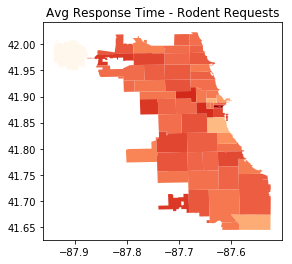

In [23]:
rjoined_resp.plot(column='count', cmap='OrRd')
plt.title('Avg Response Time - Rodent Requests')
plt.show()

### Is there any seasonality to the requests? what about seasonal variations in completion times?

In [24]:
#code

### Are there any outliers in terms of time periods or neighborhoods?

In [25]:
# code

### How do median household incomes differ by neighborhood?

In [27]:
rod_df.columns

Index(['Creation Date', 'Status', 'Completion Date', 'Service Request Number',
       'Type of Service Request', 'Number of Premises Baited',
       'Number of Premises with Garbage', 'Number of Premises with Rats',
       'Current Activity', 'Most Recent Action', 'Street Address', 'ZIP Code',
       'X Coordinate', 'Y Coordinate', 'Ward', 'Police District',
       'Community Area', 'Latitude', 'Longitude', 'Location', 'zip',
       'response_time'],
      dtype='object')

### References
http://pandas.pydata.org/pandas-docs/stable/timeseries.html

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html

http://geopandas.org/mapping.html

http://geopandas.org/mergingdata.html

http://python-visualization.github.io/folium/docs-v0.5.0/index.html

### Examples
http://blog.yhat.com/posts/interactive-geospatial-analysis.html

https://alcidanalytics.com/p/geographic-heatmap-in-python